In [1]:
import torch
import numpy as np
from scipy.io import loadmat

from timedenoiser.models.cnn import ShallowCNN
from timedenoiser.models.unet import UNET_1D

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data = loadmat('../../../datasets/Data_27012021_noisy/real/OFVC4kW_LM10Hz_paliers_0to120PercTnom_Data.mat')

# !cat ../../../datasets/Data_27012021_noisy/metadata.json

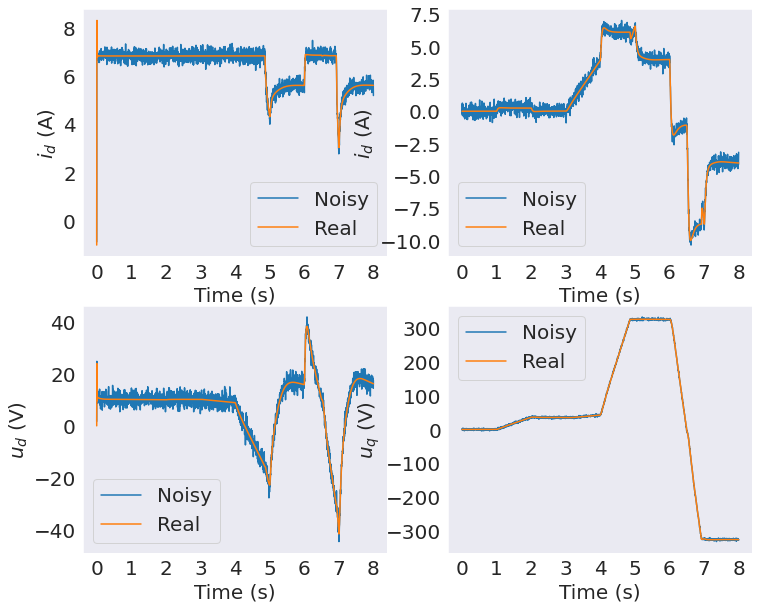

In [13]:
sns.set_style("dark")
fig = plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.plot(data['time'][0], data['noisy_current_d'][0], label='Noisy')
plt.plot(data['time'][0], data['current_d'][0], label='Real')
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 2, 2)
plt.plot(data['time'][0], data['noisy_current_q'][0], label='Noisy')
plt.plot(data['time'][0], data['current_q'][0], label='Real')
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 2, 3)
plt.plot(data['time'][0], data['noisy_voltage_d'][0], label='Noisy')
plt.plot(data['time'][0], data['voltage_d'][0], label='Real')
plt.ylabel(r'$u_d$ (V)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 2, 4)
plt.plot(data['time'][0], data['noisy_voltage_q'][0], label='Noisy')
plt.plot(data['time'][0], data['voltage_q'][0], label='Real')
plt.ylabel(r'$u_q$ (V)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [14]:
model_id = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_id.eval()
model_iq.eval()

DataParallel(
  (module): ShallowEncDec(
    (cnn1): Conv1d(1, 32, kernel_size=(10,), stride=(1,))
    (cnn2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
    (cnn3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
    (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (dcnn4): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(1,))
    (dcnn3): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(1,))
    (dcnn2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(1,))
    (dcnn1): ConvTranspose1d(32, 1, kernel_size=(10,), stride=(1,))
    (act): ReLU()
  )
)

0.27638724617011834 0.34115026509423885


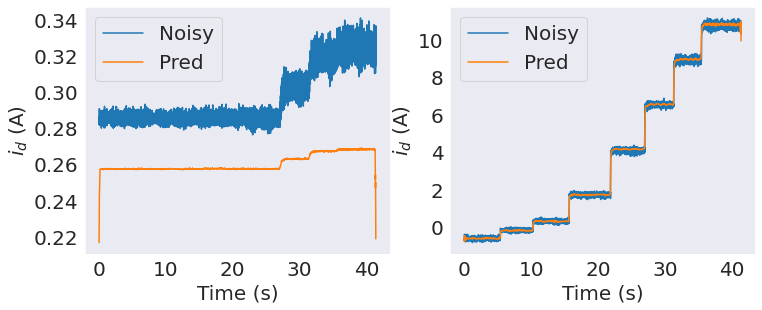

In [25]:
st = 0
w = -1

x_id = np.stack([data['noisy_current_d'][0] / 30]) 
x_iq = np.stack([data['noisy_current_q'][0] / 30])

print (x_id.min(), x_id.max())

inp_id = torch.tensor([x_id[:, st:st+w]]).cuda().float()
out_id = model_id(inp_id)
out_id = out_id.data.cpu().numpy()[0]

inp_iq = torch.tensor([x_iq[:, st:st+w]]).cuda().float()
out_iq = model_iq(inp_iq)
out_iq = out_iq.data.cpu().numpy()[0]

sns.set_style("dark")
fig = plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.plot(data['time'][0, st:st+w], data['noisy_current_d'][0, st:st+w], label='Noisy')
plt.plot(data['time'][0, st:st+w], out_id[0] * 30, label='Pred')
# plt.plot(data['time'][0, st:st+w], data['current_d'][0, st:st+w], label='Real')
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 2, 2)
plt.plot(data['time'][0, st:st+w], data['noisy_current_q'][0, st:st+w], label='Noisy')
plt.plot(data['time'][0, st:st+w], out_iq[0] * 30, label='Pred')
# plt.plot(data['time'][0, st:st+w], data['current_q'][0, st:st+w], label='Real')
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# plt.subplot(2, 2, 3)
# plt.plot(data['time'][0, st:st+w], data['noisy_voltage_d'][0, st:st+w], label='Noisy')
# plt.plot(data['time'][0, st:st+w], out[2] * 300, label='Pred')
# plt.plot(data['time'][0, st:st+w], data['voltage_d'][0, st:st+w], label='Real')
# plt.ylabel(r'$u_d$ (V)', fontsize=20)
# plt.xlabel('Time (s)', fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.legend(fontsize=20)

# plt.subplot(2, 2, 4)
# plt.plot(data['time'][0, st:st+w], data['noisy_voltage_q'][0, st:st+w], label='Noisy')
# plt.plot(data['time'][0, st:st+w], out[3] * 300, label='Pred')
# plt.plot(data['time'][0, st:st+w], data['voltage_q'][0, st:st+w], label='Real')
# plt.ylabel(r'$u_q$ (V)', fontsize=20)
# plt.xlabel('Time (s)', fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.legend(fontsize=20)
plt.show()